<a href="https://colab.research.google.com/github/marcusaxelsson1/Advanced_NN/blob/main/HWC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --pre deeptrack
!pip install --pre deeplay

### **Getting data from Deeptrack**

In [3]:
import deeptrack as dt
import numpy as np

IMAGE_SIZE = 64
sequence_length = 10  # Number of frames per sequence
MIN_SIZE = 0.5e-6
MAX_SIZE = 1.5e-6
MAX_VEL = 10  # Maximum velocity. The higher the trickier!
MAX_PARTICLES = 3  # Max number of particles in each sequence. The higher the trickier!

# Defining properties of the particles
particle = dt.Sphere(
    intensity=lambda: 10 + 10 * np.random.rand(),
    radius=lambda: MIN_SIZE + np.random.rand() * (MAX_SIZE - MIN_SIZE),
    position=lambda: IMAGE_SIZE * np.random.rand(2),
    vel=lambda: MAX_VEL * np.random.rand(2),
    position_unit="pixel",
)

# Defining an update rule for the particle position
def get_position(previous_value, vel):

    newv = previous_value + vel
    for i in range(2):
        if newv[i] > 63:
            newv[i] = 63 - np.abs(newv[i] - 63)
            vel[i] = -vel[i]
        elif newv[i] < 0:
            newv[i] = np.abs(newv[i])
            vel[i] = -vel[i]
    return newv


particle = dt.Sequential(particle, position=get_position)

# Defining properties of the microscope
optics = dt.Fluorescence(
    NA=1,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    magnification=10,
    resolution=(1e-6, 1e-6, 1e-6),
    wavelength=633e-9,
)

# Combining everything into a dataset.
# Note that the sequences are flipped in different directions, so that each unique sequence defines
# in fact 8 sequences flipped in different directions, to speed up data generation
sequential_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=sequence_length,
)
dataset = sequential_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

# Getting just two images for pretraining the CNN
two_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=2,
)
two_img_dataset = two_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

### **Exporing dataset**

In [4]:
# Generate a single batch of images
batch = dataset.update()()

# Get unique pixel values
unique_values = np.unique(batch)
print(unique_values)
print(len(unique_values))
print(np.max(unique_values))

# Check if the unique pixel values are binary
is_binary = len(unique_values) == 2 and (0 in unique_values) and (1 in unique_values)

if is_binary:
    print("The pixel values are binary (0 and 1).")
else:
    print("The pixel values are not binary.")

[1.30710443e-04 1.31895382e-04 1.32358016e-04 ... 6.21190784e+00
 6.21507153e+00 6.22318232e+00]
40960
6.223182318432385
The pixel values are not binary.


### **Plotting the images**

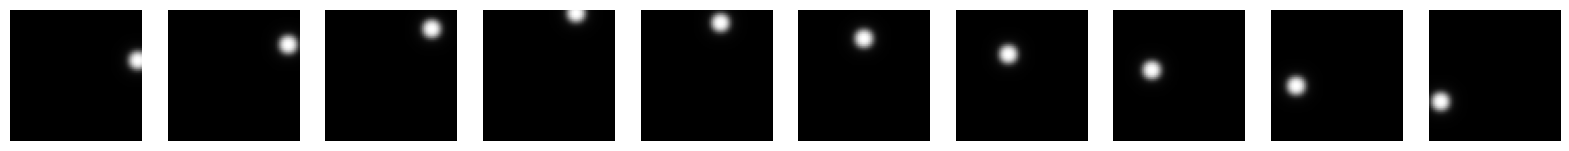

In [5]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_images(images):
    # Check if the input is a list of numpy arrays
    if isinstance(images, list):
        num_images = len(images)
        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))  # Adjust figure size as needed
        for i, img in enumerate(images):
            if img.ndim == 3 and img.shape[2] == 1:  # [H, W, 1] images
                ax = axes[i] if num_images > 1 else axes
                ax.imshow(img.squeeze(), cmap='gray')  # Squeeze to remove channel dim if it's 1
                ax.axis('off')
            else:
                raise ValueError("Image format not supported or needs additional handling for more channels.")

    # Check if the input is a PyTorch tensor
    elif isinstance(images, torch.Tensor):
        if images.dim() == 4:  # Batch of images [N, C, H, W]
            images = images.detach().cpu().numpy()  # Convert to numpy
            num_images = images.shape[0]
            fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))  # Adjust figure size as needed
            for i, img in enumerate(images):
                img = img.squeeze() if img.shape[0] == 1 else np.transpose(img, (1, 2, 0))
                ax = axes[i] if num_images > 1 else axes
                ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
                ax.axis('off')
        else:
            raise ValueError("Tensor dimension not supported for visualization.")
    else:
        raise ValueError("Unsupported data type for the images.")

# Example of how to use the function:
# Assuming 'batch' is a list of numpy arrays from dataset.update()
plot_images(batch)

### **Creating Datasets and DataLoaders**

In [6]:
import torch
from torch.utils.data import Dataset
import math
from torch.utils.data import DataLoader
import numpy as np

def generate_data(dataset, size = 256):
  data = []
  for i in range(math.floor(size/2)):
    data += dataset.update()()
  return data

#train_df = generate_data(two_img_dataset, size = 256)
#print(len(test_data))
#plot_images(test_data[:16])

import torch
from torch.utils.data import Dataset
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, pregenerated_data):
      # Calculate mean and standard deviation for z-score normalization
        all_data = np.concatenate([image.flatten() for image in pregenerated_data])
        self.mean = np.mean(all_data)
        self.std = np.std(all_data)

        # Normalize images
        self.data = [
            torch.tensor((np.moveaxis(image, -1, 0).copy() - self.mean) / self.std, dtype=torch.float32)
            for image in pregenerated_data
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Assuming two_img_dataset and generate_data are properly defined and used as before
train_df = generate_data(two_img_dataset, size = 256)
train_data = CustomDataset(train_df)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

val_df = generate_data(two_img_dataset, size = 256)
val_data = CustomDataset(val_df)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

test_df = generate_data(two_img_dataset, size = 256)
test_data = CustomDataset(test_df)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)




## **Checking how the images looks and that the dimensions are correct**

torch.Size([1, 64, 64])


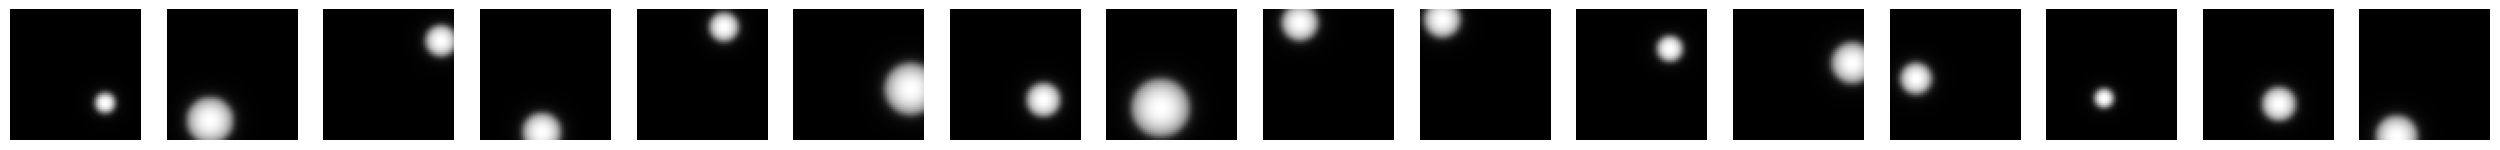

In [7]:
# Fetch one batch from the DataLoader
for images in train_loader:
    # Assuming plot_images is defined to handle a batch of images
    print(images[0].shape)  # Pass the tensor directly if your function handles tensor input
    plot_images(images)
    break  # Exit after the first batch


### **Creating the CNN**

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model8(nn.Module):
    def __init__(self):
        super(Model8, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),   # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),  # [batch, 32, H/8, W/8]
            nn.ReLU(True),
            nn.Conv2d(32, 8, 3, stride=2, padding=1),   # [batch, 8, H/16, W/16]
            nn.ReLU(True)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 32, 3, stride=2, padding=1, output_padding=1),    # [batch, 32, H/8, W/8]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1),   # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),   # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),    # [batch, 1, H, W]
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model64(nn.Module):
    def __init__(self):
        super(Model64, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [batch, 64, H/8, W/8]
            nn.ReLU(True)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),   # [batch, 1, H, W]
            nn.ReLU()  # Assuming the input is scaled between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model128(nn.Module):
    def __init__(self):
        super(Model128, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 128, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model256(nn.Module):
    def __init__(self):
        super(Model256, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 256, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model512(nn.Module):
    def __init__(self):
        super(Model512, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 128, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 512, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### **Training the models**

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_nn(model, val_loader, optimizer, loss_fn, num_epochs):

    # Store losses to return
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0

        train_df = generate_data(two_img_dataset, size = 256)
        train_data = CustomDataset(train_df)
        train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

        for images in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, images)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * images.size(0)

        # Calculate average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                outputs = model(images)
                loss = loss_fn(outputs, images)
                total_val_loss += loss.item() * images.size(0)

        # Calculate average validation loss for the epoch
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        # Print losses for the epoch
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses


### **Models with different bottleneck sizes**

In [31]:
# Create the model with bottleneck 64
model8 = Model8()

In [32]:
# Define the optimizer and loss function
optimizer = optim.Adam(model8.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 10

# Train the network
train_losses8, val_losses8 = train_nn(model8, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/15 - Train Loss: 1.1000, Val Loss: 1.0637
Epoch 2/15 - Train Loss: 0.8810, Val Loss: 0.5155
Epoch 3/15 - Train Loss: 0.3816, Val Loss: 0.2533
Epoch 4/15 - Train Loss: 0.2390, Val Loss: 0.1900
Epoch 5/15 - Train Loss: 0.1798, Val Loss: 0.1553
Epoch 6/15 - Train Loss: 0.1507, Val Loss: 0.1411
Epoch 7/15 - Train Loss: 0.1356, Val Loss: 0.1325
Epoch 8/15 - Train Loss: 0.1291, Val Loss: 0.1501
Epoch 9/15 - Train Loss: 0.1247, Val Loss: 0.1248
Epoch 10/15 - Train Loss: 0.1218, Val Loss: 0.1112
Epoch 11/15 - Train Loss: 0.1117, Val Loss: 0.1108
Epoch 12/15 - Train Loss: 0.1017, Val Loss: 0.1050
Epoch 13/15 - Train Loss: 0.0998, Val Loss: 0.1009
Epoch 14/15 - Train Loss: 0.0980, Val Loss: 0.0977
Epoch 15/15 - Train Loss: 0.0962, Val Loss: 0.1038


In [41]:
# Create the model with bottleneck 64
model64 = Model64()

In [42]:
# Define the optimizer and loss function
optimizer = optim.Adam(model64.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 10

# Train the network
train_losses64, val_losses64 = train_nn(model64, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/15 - Train Loss: 0.9327, Val Loss: 0.6866
Epoch 2/15 - Train Loss: 0.5191, Val Loss: 0.3214
Epoch 3/15 - Train Loss: 0.2735, Val Loss: 0.2330
Epoch 4/15 - Train Loss: 0.2217, Val Loss: 0.2000
Epoch 5/15 - Train Loss: 0.1859, Val Loss: 0.1772
Epoch 6/15 - Train Loss: 0.1616, Val Loss: 0.1552
Epoch 7/15 - Train Loss: 0.1533, Val Loss: 0.1478
Epoch 8/15 - Train Loss: 0.1490, Val Loss: 0.1424
Epoch 9/15 - Train Loss: 0.1170, Val Loss: 0.0949
Epoch 10/15 - Train Loss: 0.0853, Val Loss: 0.0864
Epoch 11/15 - Train Loss: 0.0848, Val Loss: 0.0827
Epoch 12/15 - Train Loss: 0.0791, Val Loss: 0.0830
Epoch 13/15 - Train Loss: 0.0816, Val Loss: 0.0805
Epoch 14/15 - Train Loss: 0.0728, Val Loss: 0.0801
Epoch 15/15 - Train Loss: 0.0734, Val Loss: 0.0788


In [35]:
model128 = Model128()

In [36]:
# Define the optimizer and loss function
optimizer = optim.Adam(model128.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 10

# Train the network
train_losses128, val_losses128 = train_nn(model128, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/15 - Train Loss: 0.9295, Val Loss: 0.6071
Epoch 2/15 - Train Loss: 0.3906, Val Loss: 0.2315
Epoch 3/15 - Train Loss: 0.1783, Val Loss: 0.1370
Epoch 4/15 - Train Loss: 0.1266, Val Loss: 0.1145
Epoch 5/15 - Train Loss: 0.1029, Val Loss: 0.1021
Epoch 6/15 - Train Loss: 0.0926, Val Loss: 0.0931
Epoch 7/15 - Train Loss: 0.0889, Val Loss: 0.0881
Epoch 8/15 - Train Loss: 0.0822, Val Loss: 0.0931
Epoch 9/15 - Train Loss: 0.0843, Val Loss: 0.0831
Epoch 10/15 - Train Loss: 0.0795, Val Loss: 0.0814
Epoch 11/15 - Train Loss: 0.0741, Val Loss: 0.0803
Epoch 12/15 - Train Loss: 0.0792, Val Loss: 0.0791
Epoch 13/15 - Train Loss: 0.0669, Val Loss: 0.0784
Epoch 14/15 - Train Loss: 0.0728, Val Loss: 0.0774
Epoch 15/15 - Train Loss: 0.0747, Val Loss: 0.0767


In [49]:
model256 = Model256()

In [50]:
# Define the optimizer and loss function
optimizer = optim.Adam(model256.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 10

# Train the network
train_losses256, val_losses256 = train_nn(model256, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/15 - Train Loss: 0.6378, Val Loss: 0.3239
Epoch 2/15 - Train Loss: 0.2517, Val Loss: 0.2040
Epoch 3/15 - Train Loss: 0.1785, Val Loss: 0.1326
Epoch 4/15 - Train Loss: 0.1187, Val Loss: 0.1030
Epoch 5/15 - Train Loss: 0.0922, Val Loss: 0.0925
Epoch 6/15 - Train Loss: 0.0832, Val Loss: 0.0877
Epoch 7/15 - Train Loss: 0.0835, Val Loss: 0.0850
Epoch 8/15 - Train Loss: 0.0840, Val Loss: 0.0830
Epoch 9/15 - Train Loss: 0.0843, Val Loss: 0.0821
Epoch 10/15 - Train Loss: 0.0754, Val Loss: 0.0809
Epoch 11/15 - Train Loss: 0.0799, Val Loss: 0.0812
Epoch 12/15 - Train Loss: 0.0735, Val Loss: 0.0815
Epoch 13/15 - Train Loss: 0.0738, Val Loss: 0.0799
Epoch 14/15 - Train Loss: 0.0753, Val Loss: 0.0798
Epoch 15/15 - Train Loss: 0.0744, Val Loss: 0.0794


In [75]:
model512 = Model512()

In [76]:
# Define the optimizer and loss function
optimizer = optim.Adam(model512.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 10

# Train the network
train_losses512, val_losses512 = train_nn(model512, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/15 - Train Loss: 0.5554, Val Loss: 0.2093
Epoch 2/15 - Train Loss: 0.1714, Val Loss: 0.1157
Epoch 3/15 - Train Loss: 0.1170, Val Loss: 0.1012
Epoch 4/15 - Train Loss: 0.0914, Val Loss: 0.0787
Epoch 5/15 - Train Loss: 0.0765, Val Loss: 0.0731
Epoch 6/15 - Train Loss: 0.0738, Val Loss: 0.0700
Epoch 7/15 - Train Loss: 0.0740, Val Loss: 0.0688
Epoch 8/15 - Train Loss: 0.0682, Val Loss: 0.0691
Epoch 9/15 - Train Loss: 0.0678, Val Loss: 0.0694
Epoch 10/15 - Train Loss: 0.0689, Val Loss: 0.0683
Epoch 11/15 - Train Loss: 0.0737, Val Loss: 0.0736
Epoch 12/15 - Train Loss: 0.0693, Val Loss: 0.0675
Epoch 13/15 - Train Loss: 0.0679, Val Loss: 0.0673
Epoch 14/15 - Train Loss: 0.0705, Val Loss: 0.0674
Epoch 15/15 - Train Loss: 0.0677, Val Loss: 0.0672


### **Visualizing the results**

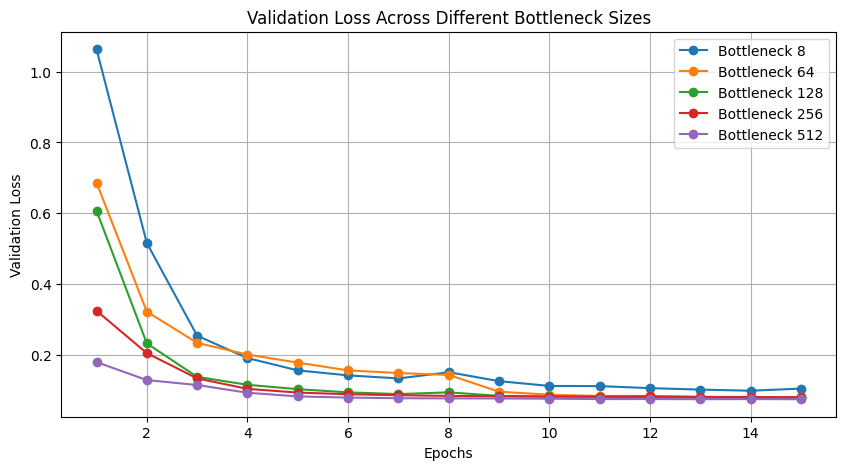

In [51]:
# Assuming all models were trained for the same number of epochs
epochs = range(1, len(val_losses8) + 1)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_losses8, label='Bottleneck 8', marker='o')
plt.plot(epochs, val_losses64, label='Bottleneck 64', marker='o')
plt.plot(epochs, val_losses128, label='Bottleneck 128', marker='o')
plt.plot(epochs, val_losses256, label='Bottleneck 256', marker='o')
plt.plot(epochs, val_losses512, label='Bottleneck 512', marker='o')

plt.title('Validation Loss Across Different Bottleneck Sizes')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Process images from test_loader
with torch.no_grad():
    for images in test_loader:

        plot_images(images)

        outputs8 = model8(images)
        plot_images(outputs8)

        outputs64 = model64(images)
        plot_images(outputs64)

        outputs128 = model128(images)
        plot_images(outputs128)

        outputs256 = model256(images)
        plot_images(outputs256)

        outputs512 = model512(images)
        plot_images(outputs512)

        break  # Remove break to process more batches

### **VISION ENCODER**

In [63]:
# Generate a large number of sequences to create the dataset
num_sequences = 128  # This is just an example; adjust based on your computational resources
all_sequences = [sequential_images.update()() for _ in range(num_sequences)]


In [70]:
def generate_seq_data(num_seqs, seq_length):
  generator = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=seq_length,
  )

  data = []
  for i in range(num_seqs):
    data.append(generator.update()())

  return data


In [71]:
test = generate_seq_data(num_seqs = 16, seq_length = 12)
print(len(test))
print(len(test[0]))

16
12


### **Transformer Encoder**

In [84]:
import torch
import torch.nn as nn

class PatchEmbedder(nn.Module):
    def __init__(self, image_size=64, patch_size=8, embedding_dim=512):
        super(PatchEmbedder, self).__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.num_patches = (image_size // patch_size) * (image_size // patch_size)
        self.projection = nn.Conv2d(1, embedding_dim, kernel_size=patch_size, stride=patch_size)

        # Positional embeddings
        self.positional_embedding = nn.Parameter(torch.randn(1, self.num_patches, embedding_dim))

    def forward(self, x):
        # Reshape input image into patches
        x = self.projection(x)
        # Reshape patches into a sequence
        x = x.view(x.size(0), self.num_patches, self.embedding_dim)
        # Add positional embeddings
        x += self.positional_embedding
        # Transpose to make the sequence the second dimension (batch_size, num_patches, embedding_dim)
        #x = x.transpose(1, 2)
        return x


# Testing the patch embedder
image = torch.randn(1, 1, 64, 64)  # Batch size 1, single channel, 64x64 image
patch_embedder = PatchEmbedder()
output = patch_embedder(image)
print("Output shape:", output.shape)


Output shape: torch.Size([1, 64, 512])


In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embedding_dim=512, num_heads=3, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.linear1 = nn.Linear(embedding_dim, 2048)
        self.dropout2 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(2048, embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        # Multi-Head Self Attention
        x_res = x
        x = self.self_attn(x, x, x)[0]
        x = self.dropout1(x)
        # Add skip connection and apply layer normalization
        x = self.norm1(x + x_res)

        # MLP layer
        x_res = x
        x = F.relu(self.linear1(x))
        x = self.dropout2(x)
        x = self.linear2(x)
        # Add skip connection and apply layer normalization
        x = self.norm2(x + x_res)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, patch_embedder, embedding_dim=512, num_heads=8, num_layers=6, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.patch_embedder = patch_embedder
        self.layers = nn.ModuleList([TransformerEncoderLayer(embedding_dim, num_heads, dropout) for _ in range(num_layers)])

    def forward(self, x):
      # Patch input image
      #print("Input shape:", x.shape)
      x = self.patch_embedder(x)
      #print("Patch embedding shape:", x.shape)
      # Apply each Transformer Encoder layer
      for layer in self.layers:
          x = layer(x)
          #print("Layer output shape:", x.shape)
      return x


# Testing the Transformer Encoder
image = torch.randn(1, 1, 64, 64)  # Batch size 1, single channel, 64x64 image
transformer_encoder = TransformerEncoder(patch_embedder)
output = transformer_encoder(image)
#print("Output shape:", output.shape)


In [86]:
import torch
import torch.nn as nn

class ViT(nn.Module):
    def __init__(self, transformer_encoder, decoder):
        super(ViT, self).__init__()
        self.transformer_encoder = transformer_encoder
        self.decoder = decoder

    def forward(self, x):
      # Pass input through Transformer encoder
      x = self.transformer_encoder(x)
      # Reshape output to match expected input shape of the decoder
      x = x.view(x.size(0), 512, 8, 8)  # Reshape from [1, 64, 512] to [1, 512, 8, 8]
      # Pass the reshaped output through the decoder
      x = self.decoder(x)
      return x

# Instantiate your trained decoder
decoder = model512.decoder

# Instantiate the Transformer encoder (assuming it's already instantiated)
transformer_encoder = TransformerEncoder(patch_embedder)

# Combine the Transformer encoder and the decoder into a single model
ViT_model = ViT(transformer_encoder, decoder)



In [87]:
# Assuming you have an image tensor named 'image'
image = torch.randn(1, 1, 64, 64)  # Sample image tensor

# Pass the image through the ViT_model
with torch.no_grad():
    output = ViT_model(image)

# Print the shape of the output to ensure it matches your expectations
#print("Output shape:", output.shape)

# Optionally, you can print the output itself for inspection
#print("Output:", output)


In [ ]:
# Loss function
criterion = torch.nn.MSELoss()  # Example for a reconstruction task

# Optimizer (only optimizing the transformer encoder's parameters)
optimizer = torch.optim.Adam(transformer_encoder.parameters(), lr=0.001)

# Example training loop
for epoch in range(num_epochs):
    for images in train_loader:  # Assuming images are your input data

        optimizer.zero_grad()       # Zero the parameter gradients
        outputs = ViT_model(images) # Forward pass through the whole model
        loss = criterion(outputs, images)  # Compute loss; may vary based on task
        loss.backward()             # Backpropagation
        optimizer.step()            # Optimize only the encoder

        print(f"Epoch {epoch}, Loss: {loss.item()}")  # Print loss for monitoring

    # Save model/checkpoint if necessary or evaluate on validation set


In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_ViT(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    # Ensure decoder's weights are frozen
    for param in model.decoder.parameters():
        param.requires_grad = False

    # Store losses to track progress
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0

        for images in train_loader:
            optimizer.zero_grad()  # Zero the gradient buffers
            outputs = model(images)  # Forward pass: compute predicted outputs by the model
            loss = criterion(outputs, images)  # Calculate the loss based on the model's output and actual data
            loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
            optimizer.step()  # Perform a single optimization step (parameter update)
            total_train_loss += loss.item() * images.size(0)  # Sum up total loss for the epoch

        # Calculate average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():  # Context-manager that disables gradient calculation
            for images in val_loader:
                outputs = model(images)  # Forward pass: compute predicted outputs by the model
                loss = criterion(outputs, images)  # Calculate the loss
                total_val_loss += loss.item() * images.size(0)  # Sum up total loss for the epoch

        # Calculate average validation loss for the epoch
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        # Print losses for the epoch
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses

# Example usage

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, ViT_model.parameters()), lr=0.001)  # Optimizer only for the trainable parameters
criterion = torch.nn.MSELoss()  # Loss function

# Assuming train_loader and val_loader are defined somewhere
train_losses, val_losses = train_ViT(ViT_model, train_loader, val_loader, optimizer, criterion, num_epochs=10)


Epoch 1/10 - Train Loss: 1.1257, Val Loss: 1.0040
Epoch 2/10 - Train Loss: 1.0026, Val Loss: 1.0032
Epoch 3/10 - Train Loss: 1.0020, Val Loss: 1.0022
Epoch 4/10 - Train Loss: 1.0018, Val Loss: 1.0005
Epoch 5/10 - Train Loss: 0.9997, Val Loss: 1.0020
Epoch 6/10 - Train Loss: 0.9994, Val Loss: 1.0028
Epoch 7/10 - Train Loss: 0.9986, Val Loss: 1.0024
Epoch 8/10 - Train Loss: 0.9994, Val Loss: 1.0043
Epoch 9/10 - Train Loss: 1.0003, Val Loss: 1.0035


KeyboardInterrupt: 